In [251]:
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [252]:
df = pd.read_csv("listings.csv")
df[:2]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.36435,4.94358,Private room,60,3,278,2019-11-21,2.90,1,137
1,20168,Studio with private bathroom in the centre 1,59484,Alexander,NaN,Centrum-Oost,52.36407,4.89393,Private room,106,1,339,2020-03-27,3.73,2,0


In [253]:
#data cleaning
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df.drop(['neighbourhood_group'], inplace=True, axis=1)

In [254]:
#removing recrods with outlier prices 
print(df['price'].describe())
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['price'] < (Q1 - 1.5 * IQR)) |(df['price'] > (Q3 + 1.5 * IQR)))]
print(df['price'].describe())

count    16724.00000
mean       156.15977
std        172.48717
min          0.00000
25%         95.00000
50%        129.00000
75%        180.00000
max       8000.00000
Name: price, dtype: float64
count    15842.000000
mean       135.715629
std         58.986716
min          0.000000
25%         94.250000
50%        125.000000
75%        170.000000
max        307.000000
Name: price, dtype: float64


In [255]:
#scaling the data 
#scaling the data 
norm_col = ['latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

df_norm = df.copy()

for name in norm_col:
    df_norm[name] = (df_norm[name] - df_norm[name].min())/(df_norm[name].max() - df_norm[name].min())

### KNN Model via cross validaiton

In [256]:
#loading requried library 
from patsy import dmatrices
from sklearn import preprocessing
%pylab inline
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import metrics
from sklearn import model_selection

#creating the dmatrice    
Y, X = dmatrices('price ~ 0 + neighbourhood + room_type + latitude + longitude', df_norm, return_type = "dataframe")

#storing Y values in a list 
y = Y['price'].values

Populating the interactive namespace from numpy and matplotlib


In [311]:
import math
from sklearn.model_selection import ShuffleSplit

a = df['price'].max()
b = df['price'].min()

def de_norm(MSE) : 
    return (MSE*(a-b))+b


def cv_accuracy_score(X, y, nn):
    """For each fold, fit the nearest neighbors model
    with nn nearest neighbors on the train, and return accuracy
    on the test."""
    
    MSE_array = []
    model = neighbors.KNeighborsRegressor(n_neighbors=nn,
                                           weights='uniform')
    
    kfold = ShuffleSplit(n_splits=3, random_state=None).split(X, y)
    
    for train, holdout in kfold:
        # Select the training and testing data using the indices
        # provided by kfold
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Compute test accuracy
        MSE = average((de_norm(model.predict(X_holdout)) - de_norm(y_holdout))**2)
        MSE_array.append(MSE)
    return math.sqrt(average(MSE_array))

cv_accuracy_score(X,y,15)

52.949546835703146

Text(0, 0.5, 'MSE in Price')

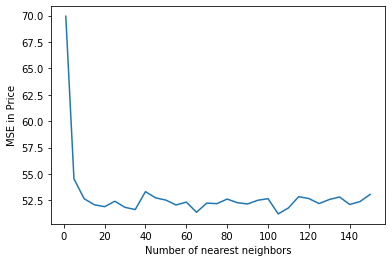

In [312]:
#plotting the MSE vs k curve to identify k corresponsing to minimum MSE
nn = [1] + [(x + 1) * 5 for x in range(30)]
scores = [cv_accuracy_score(X, y, num_nbrs) for num_nbrs in nn]
plot(nn, scores)
xlabel('Number of nearest neighbors')
ylabel('MSE in Price')

In [313]:
min_score = min(scores)
for i in range(len(scores)):
    if scores[i] == min_score:
        index = i
        break
print("K value for minimum MSE of ",round(scores[index],2)," is :",nn[index])

K value for minimum MSE of  51.22  is : 105


In [314]:
print("MSE for model with K = 105 is :",cv_accuracy_score(X,y,105))

MSE for model with K = 105 is : 51.28750154475014


## Clustering

1